# Capstone Project - NYC Taxi Trips

It is a capstone project that requires to create custom features to understand NYC taxi trip patterns, based on the existing dataset. The dataset is from the classic NYC taxi trip dataset from Kaggle. The aim is to predict the travel time according to other features.

Create a few functions below to make the code clean and tidy

In [2]:
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values(kind='mergesort').head(n).index
    return df.loc[order]


def feature_importances(model, feature_names, n=10):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i + 1, f[0], f[1]))


def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows - head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = Imputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test, y_test)

def column_string(n):
    string = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        string = chr(65 + remainder) + string
    return string


def load_nyc_taxi_data():
    trips = pd.read_pickle('trips.pkl')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv(
        "pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv(
        "dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods


def compute_features(features, entityset,cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    #np.random.shuffle(features)
    feature_matrix = ft.computational_backends.calculate_feature_matrix(features,
                                                                        entityset,
                                                                        cutoff_time=cutoff_time,
                                                                       approximate='36d')
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=[
                                                      "pickup_neighborhood",
                                                      "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix




In [3]:
import featuretools as ft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,
                                     Minute, Month, Std, Sum, Week, Weekday,
                                     Weekend)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer


In [4]:
# Load the dataset and check 10 rows of data and also the features
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I
5,514035,1,2016-04-02 00:01:00,2016-04-02 00:09:00,2,1.50,-73.981956,40.765518,-73.968124,40.753407,1,458,AR,N
6,514036,1,2016-04-02 00:01:00,2016-04-02 00:05:00,1,1.50,-73.980019,40.780594,-73.968132,40.799595,2,213,AV,U
7,514037,1,2016-04-02 00:01:00,2016-04-02 00:20:00,1,4.20,-73.990501,40.756561,-73.986008,40.719414,2,1142,AA,AC
8,514038,1,2016-04-02 00:01:00,2016-04-02 00:10:00,1,0.60,-73.986198,40.730492,-73.991798,40.722240,1,501,AT,AC
9,514039,1,2016-04-02 00:01:00,2016-04-02 00:17:00,1,0.60,-73.990959,40.734890,-74.001816,40.739319,1,954,R,Q


Text(0.5,0.98,'Trip Duration Distribution')

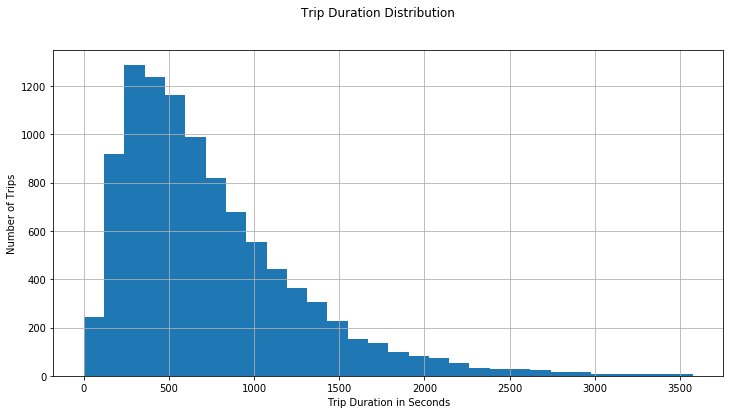

In [6]:
# Have a quick look at the histgram of the target column
plt.figure(figsize=(12,6))
trips.trip_duration.hist(bins=30)
plt.xlabel('Trip Duration in Seconds')
plt.ylabel('Number of Trips')
plt.suptitle('Trip Duration Distribution')

In [9]:
# Quick overview of the categorical columns
trips['pickup_neighborhood'].value_counts().sort_values(ascending=False).head()

AA    444
D     434
AC    407
AB    407
AO    396
Name: pickup_neighborhood, dtype: int64

### EDA
Do the EDA and see if there is any inter-relationship we can find from the features and target

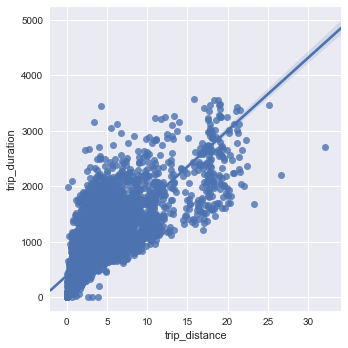

In [67]:
# First, it is easy to relate the trip distance to the trip duration. And it is reasonable to assume that they
# are likely to have a linear relationship
sns.set(color_codes=True)
sns.lmplot(x='trip_distance',y='trip_duration',data=trips,palette='Set1')

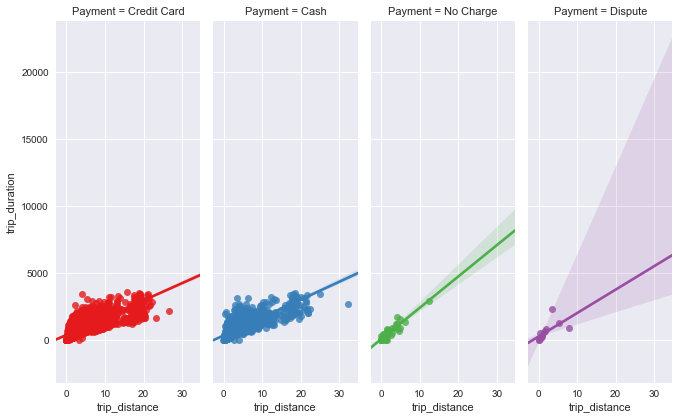

In [68]:
# we can also convert the payment_type from numerical numbers to categorical data
# and then plot the same graph with the added third variable
Cat = {'1':'Credit Card', '2':'Cash', '3':'No Charge', '4':'Dispute'}
payment = trips['payment_type'].map(Cat)
trips['Payment'] = payment

sns.set(color_codes=True)
sns.lmplot(x='trip_distance',y='trip_duration',hue='Payment', col ='Payment',
           size=6,aspect=.4,x_jitter=.1,data=trips,palette='Set1')

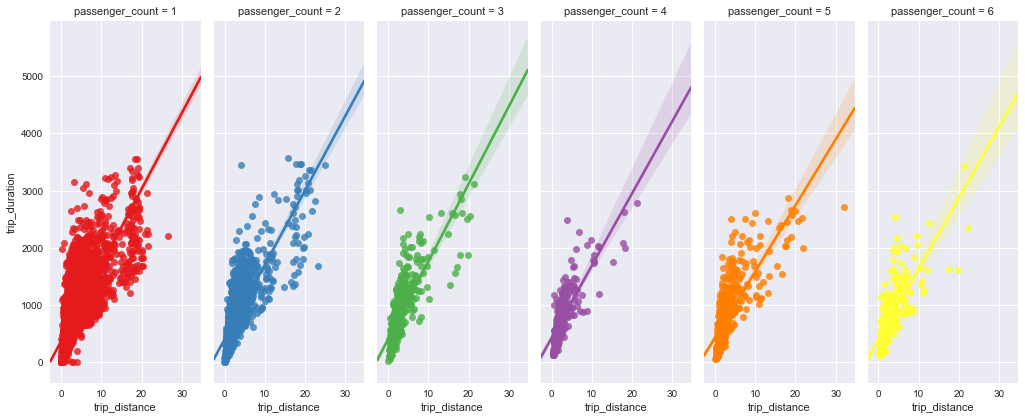

In [69]:
# check the same plots but replace the payment_type with the number of passengers
sns.set(color_codes=True)
sns.lmplot(x='trip_distance',y='trip_duration',hue='passenger_count', col ='passenger_count',
           size=6,aspect=.4,x_jitter=.1,data=trips,palette='Set1')

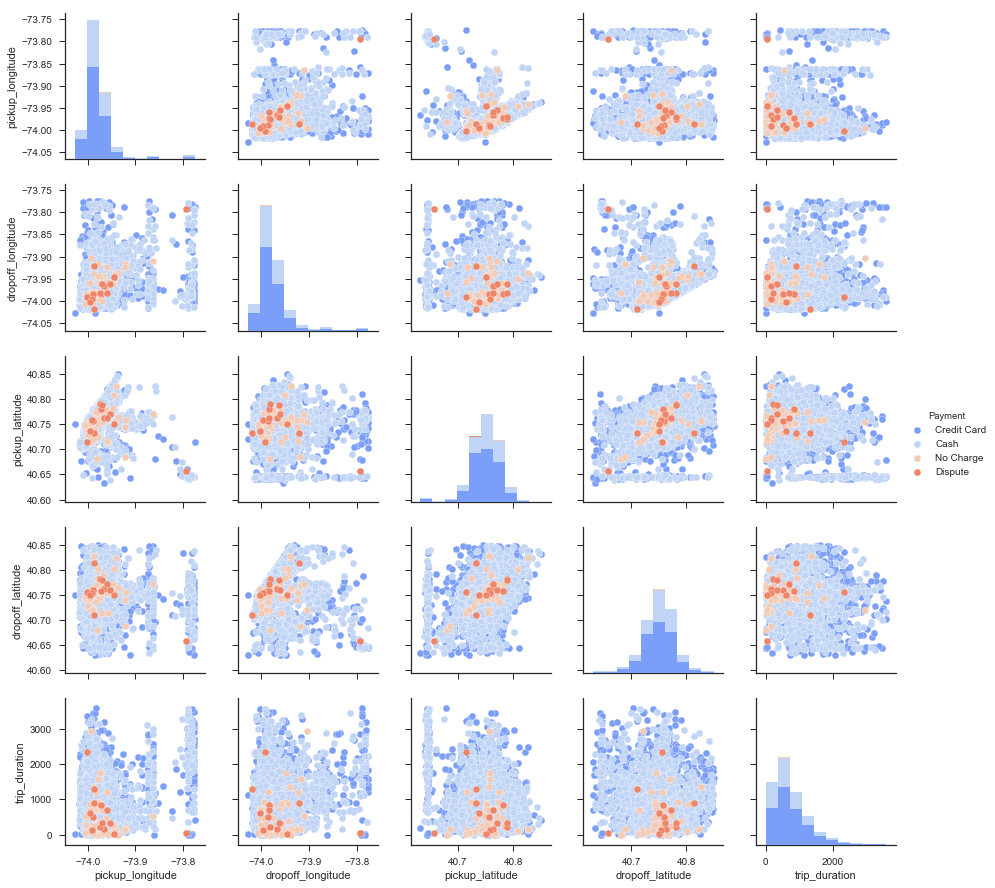

In [70]:
# now have a look and see if there is any inner patterns between the pickup/dropoff location, 
# trip duration and payment
col_to_pair = ['pickup_longitude','dropoff_longitude','pickup_latitude',
               'dropoff_latitude','trip_duration','Payment']

sns.set(style='ticks',color_codes=True)
sns.pairplot(trips[col_to_pair],hue='Payment',palette='coolwarm')


### Feature Engineering
It can be seen from the dataset that there are 3 main entities: trips, pickup neighborhoods, dropoff neighborhoods.

We can then have 2 relationships: *pickup_neighborhoods* to *trips* and *dropoff_neighborhoods* to *trips*

#### Transform primitives 1
Create new features and see if the pickup/dropoff time is in the weekend

In [71]:
trips.drop(['Payment'],axis=1,inplace=True)
entities = {
    "trips": (trips, "id", 'pickup_datetime'),
    "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
    "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
}

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

In [96]:
trans_primitives = [Weekend]

# This may take some time to compute
features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

entityset = ft.EntitySet('entityset',entities,relationships)
entityset

Entityset: entityset
  Entities:
    trips [Rows: 10000, Columns: 14]
    pickup_neighborhoods [Rows: 50, Columns: 3]
    dropoff_neighborhoods [Rows: 50, Columns: 3]
  Relationships:
    trips.pickup_neighborhood -> pickup_neighborhoods.neighborhood_id
    trips.dropoff_neighborhood -> dropoff_neighborhoods.neighborhood_id

In [87]:
print(f"Number of features: {len(features)}")
features[0]

Number of features: 13


<Feature: vendor_id>

In [98]:
# Compute the new feature matrix and also convert the categorical columns using dummy variables
feature_matrix = compute_features(features,entityset, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)

Finishing computing...


,vendor_id,passenger_count,trip_distance,payment_type,trip_duration,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = AC,pickup_neighborhood = AB,pickup_neighborhood = AO,...,dropoff_neighborhood = A,dropoff_neighborhood = AB,dropoff_neighborhood = AV,dropoff_neighborhood = AP,WEEKEND(pickup_datetime),WEEKEND(dropoff_datetime),pickup_neighborhoods.latitude,pickup_neighborhoods.longitude,dropoff_neighborhoods.latitude,dropoff_neighborhoods.longitude
id,,,,,,,,,,,,,,,,,,,,,
514030,2,1,2.46,1,1039,1,0,0,0,0,...,0,0,0,0,True,True,40.757707,-73.986446,40.766809,-73.956886
514031,1,2,7.90,1,1454,0,0,0,0,0,...,0,0,0,0,True,True,40.744928,-73.919159,40.793597,-73.969822
514032,1,1,1.00,1,1168,0,0,0,0,0,...,0,0,0,0,True,True,40.729652,-73.991595,40.740333,-74.005107
514033,2,1,0.02,2,35,0,0,1,0,0,...,0,0,0,0,True,True,40.720245,-73.987205,40.720245,-73.987205
514034,1,2,19.00,1,3470,0,0,0,0,0,...,0,0,0,0,True,True,40.646194,-73.785073,40.785005,-73.976050


In [101]:
# Split data
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [102]:
# Train the model with gradient boosting
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test) # This is the R^2 value of the prediction
#model.score(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.4736            1.30s
         2           0.4148            1.04s
         3           0.3661            0.94s
         4           0.3266            0.90s
         5           0.2934            0.95s
         6           0.2665            0.90s
         7           0.2441            0.89s
         8           0.2257            0.86s
         9           0.2103            0.83s
        10           0.1973            0.80s
        20           0.1434            0.62s
        30           0.1312            0.51s
        40           0.1248            0.40s
        50           0.1218            0.31s
        60           0.1191            0.23s
        70           0.1174            0.16s
        80           0.1158            0.11s
        90           0.1147            0.05s
       100           0.1137            0.00s


0.752768389966389

2 new features added in are 2 weekend transform features on whether or not the dropoff or pickup date is in the weekend. I think these certainly improved the model as it captures more features. It helps to indicate if the trips occurred in the weekends or in the week days. The R-squared value is 0.7527, which is a good number, as the higher the value, the better the model fits the data.

#### Transform primitives 2
Create more features (such as the minute,hour,day,week,month of the pickup/dropoff time)

In [103]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [104]:
feature_matrix = compute_features(features,entityset, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)

Finishing computing...


,vendor_id,passenger_count,trip_distance,payment_type,trip_duration,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = AC,pickup_neighborhood = AB,pickup_neighborhood = AO,...,MONTH(pickup_datetime),MONTH(dropoff_datetime),WEEKDAY(pickup_datetime),WEEKDAY(dropoff_datetime),WEEKEND(pickup_datetime),WEEKEND(dropoff_datetime),pickup_neighborhoods.latitude,pickup_neighborhoods.longitude,dropoff_neighborhoods.latitude,dropoff_neighborhoods.longitude
id,,,,,,,,,,,,,,,,,,,,,
514030,2,1,2.46,1,1039,1,0,0,0,0,...,4,4,5,5,True,True,40.757707,-73.986446,40.766809,-73.956886
514031,1,2,7.90,1,1454,0,0,0,0,0,...,4,4,5,5,True,True,40.744928,-73.919159,40.793597,-73.969822
514032,1,1,1.00,1,1168,0,0,0,0,0,...,4,4,5,5,True,True,40.729652,-73.991595,40.740333,-74.005107
514033,2,1,0.02,2,35,0,0,1,0,0,...,4,4,5,5,True,True,40.720245,-73.987205,40.720245,-73.987205
514034,1,2,19.00,1,3470,0,0,0,0,0,...,4,4,5,5,True,True,40.646194,-73.785073,40.785005,-73.976050


In [105]:
# Re-split data
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [106]:
# Train the model with the same algorithm and see the change in the R-squared value
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test) # This is the R^2 value of the prediction

      Iter       Train Loss   Remaining Time 
         1           0.4736            1.04s
         2           0.4148            1.01s
         3           0.3661            0.98s
         4           0.3264            1.04s
         5           0.2930            0.99s
         6           0.2660            0.97s
         7           0.2432            0.94s
         8           0.2245            0.95s
         9           0.2090            0.93s
        10           0.1960            0.91s
        20           0.1362            0.74s
        30           0.1200            0.62s
        40           0.1126            0.49s
        50           0.1079            0.38s
        60           0.1047            0.29s
        70           0.1016            0.21s
        80           0.0986            0.13s
        90           0.0938            0.06s
       100           0.0899            0.00s


0.8061272095154233

The new features include the exact time of the pickup/dropoff, such as the minute, hour, day, week and month. By adding this information, it improves the overall performance as the R-squared value increases to 0.805595. The higher the R-squared value, the better the model fits. At the same time, it would sacrifice the training time since the size of the feature matrix gets larger, which can be observed from the third column of the results.

#### Aggregation primitives
There are a number of aggregation methods that we can use too create features. In this case, basic functions such as count/sum/mean/etc are applied on the location of the pickup/dropoff to test the performance.

In [107]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, Weekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [108]:
feature_matrix = compute_features(features, entityset, trips[['id', 'pickup_datetime']])
preview(feature_matrix, 5)

Finishing computing...


,vendor_id,passenger_count,trip_distance,payment_type,trip_duration,pickup_neighborhood = AA,pickup_neighborhood = D,pickup_neighborhood = AC,pickup_neighborhood = AB,pickup_neighborhood = AO,...,dropoff_neighborhoods.STD(trips.trip_distance),dropoff_neighborhoods.STD(trips.trip_duration),dropoff_neighborhoods.MAX(trips.vendor_id),dropoff_neighborhoods.MAX(trips.passenger_count),dropoff_neighborhoods.MAX(trips.trip_distance),dropoff_neighborhoods.MAX(trips.trip_duration),dropoff_neighborhoods.MIN(trips.vendor_id),dropoff_neighborhoods.MIN(trips.passenger_count),dropoff_neighborhoods.MIN(trips.trip_distance),dropoff_neighborhoods.MIN(trips.trip_duration)
id,,,,,,,,,,,,,,,,,,,,,
514037,1,1,4.20,2,1142,1,0,0,0,0,...,2.264538,555.800624,2.0,1.0,4.20,1142.0,1.0,1.0,0.02,35.0
514048,1,2,7.90,1,1335,0,0,0,0,0,...,4.242641,458.205194,1.0,2.0,7.90,1335.0,1.0,1.0,1.90,687.0
514049,1,1,0.40,2,302,0,0,0,1,0,...,1.859691,302.641702,2.0,3.0,3.03,730.0,1.0,1.0,0.40,302.0
514052,2,5,12.06,1,1411,0,0,0,0,0,...,5.544078,622.315769,2.0,5.0,12.06,1411.0,1.0,1.0,0.02,35.0
514053,2,1,1.49,2,370,0,0,0,0,0,...,3.697932,675.744774,2.0,2.0,7.90,1454.0,1.0,1.0,1.49,213.0


In [110]:
# Re-split data
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix,.75)
y_train = np.log(y_train + 1)
y_test = np.log(y_test + 1)

In [111]:
# Train the model with the same algorithm and see the change in the R-squared value
model = GradientBoostingRegressor(verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test) # This is the R^2 value of the prediction

      Iter       Train Loss   Remaining Time 
         1           0.4736            3.85s
         2           0.4148            3.32s
         3           0.3661            3.09s
         4           0.3264            2.99s
         5           0.2930            2.89s
         6           0.2659            2.83s
         7           0.2431            2.78s
         8           0.2243            2.77s
         9           0.2088            2.72s
        10           0.1957            2.67s
        20           0.1348            2.28s
        30           0.1168            1.96s
        40           0.1073            1.66s
        50           0.1000            1.33s
        60           0.0950            1.04s
        70           0.0916            0.75s
        80           0.0885            0.49s
        90           0.0863            0.24s
       100           0.0845            0.00s


0.7782078449175037

As can be seen, adding too many features does not guarantee a better fit to the model. 

### Evaluate on the predictions

In [112]:
# Use the trained model to predict
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1 # undo the log we took earlier

In [113]:
# Print the first 5 predictions
y_pred[:5]

array([483.93540302, 730.06528916, 781.55068544, 677.7096874 ,
       458.73667311])

(array([426., 740., 503., 330., 238., 111.,  64.,  49.,  24.,  15.]),
 array([   8.71606273,  275.28105637,  541.84605001,  808.41104365,
        1074.97603729, 1341.54103094, 1608.10602458, 1874.67101822,
        2141.23601186, 2407.8010055 , 2674.36599915]),
 <a list of 10 Patch objects>)

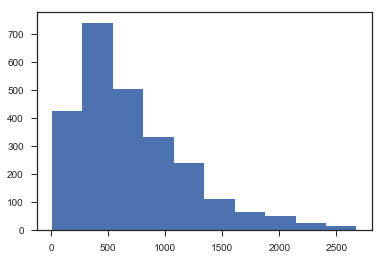

In [114]:
# Create a histogram of all of predictions
matplotlib.pyplot.hist(y_pred)

The predictions have a very similar shape to the one I made at the beginning, which shows a good and accurate prediction result

### Feature importance
It is useful to analyze the feature importance values of the model we computed, from which we can tell which features matter the most to the result.

In [120]:
# Show the top 15 features
feature_importances(model, feature_matrix.columns, n=15)

1: Feature: trip_distance, 0.294
2: Feature: MINUTE(dropoff_datetime), 0.067
3: Feature: dropoff_neighborhoods.MIN(trips.trip_distance), 0.049
4: Feature: dropoff_neighborhoods.STD(trips.trip_distance), 0.031
5: Feature: dropoff_neighborhoods.latitude, 0.031
6: Feature: dropoff_neighborhoods.MEAN(trips.trip_distance), 0.030
7: Feature: WEEKEND(dropoff_datetime), 0.029
8: Feature: pickup_neighborhoods.MIN(trips.trip_distance), 0.028
9: Feature: pickup_neighborhoods.MEAN(trips.passenger_count), 0.028
10: Feature: pickup_neighborhoods.longitude, 0.026
11: Feature: dropoff_neighborhoods.MEDIAN(trips.passenger_count), 0.025
12: Feature: HOUR(pickup_datetime), 0.022
13: Feature: pickup_neighborhoods.MEAN(trips.trip_distance), 0.022
14: Feature: dropoff_neighborhoods.STD(trips.passenger_count), 0.021
15: Feature: dropoff_neighborhoods.MEDIAN(trips.trip_distance), 0.019


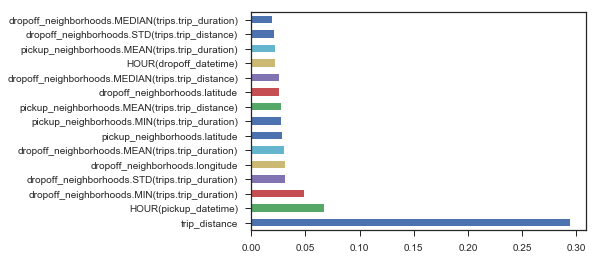

In [128]:
# It would be nice and intuitive to present the result in a graph
feature_matrix_drop = feature_matrix.drop('trip_duration',axis=1)
(pd.Series(model.feature_importances_, index=feature_matrix_drop.columns)
   .nlargest(15)
   .plot(kind='barh'))